# Computer Vision Coursework

In [180]:
### Importing necessary libraries
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import time

## Exploratory Data Analysis

### Basic Stats

In [181]:
### Loading matlab files in Python using Scipy
import scipy.io
mat = scipy.io.loadmat('Brain.mat')

In [182]:
T1, label = mat['T1'], mat['label']

In [183]:
### T1 is the array with the input MRI images, 10 samples each of size 362x434 pixels.
T1.shape

(362, 434, 10)

In [184]:
### range of pixel values in a sample of T1
sample = T1[:,:,0]
print(f"""Max pixel value: {round(sample.min(),0)}, 
Min pixel value: {round(sample.max(),0)},
Average pixel value: {round(sample.mean(),0)}""")

Max pixel value: 959.0, 
Min pixel value: 491434.0,
Average pixel value: 164930.0


- From the above cell, we can see that the obtained input image is not in standard color range `0-255`. Thus, we need to apply the standardisation technique `(x -> (x-xmin)/(xmax-xmin))` that will convert the pixel to the range `[0,1]`. Multiply the obtained pixel values with 255 and take the integer value to get the standard `0-255` representation of the image

In [185]:
sample_std = ((sample - sample.min()) * (1/(sample.max() - sample.min()) * 255)).astype('uint8')
print(f"""Standardized image:
Max pixel value: {round(sample_std.min(),0)}, 
Min pixel value: {round(sample_std.max(),0)},
Average pixel value: {round(sample_std.mean(),0)}""")

Standardized image:
Max pixel value: 0, 
Min pixel value: 255,
Average pixel value: 85.0


### Visualising images

In [186]:
### function to plot single image
def show_image(image,cmap = 'gray',fig_size = 5):
    plt.figure(figsize = (fig_size,fig_size))
    fig  = plt.imshow(image,cmap = cmap)
    plt.show()

### function to visualise label images
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    # convert hsv2bgr for visualsiation
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    # set background label to black
    labeled_img[label_hue==0] = 0
    return labeled_img

### function to plot multiple images as subplot
def plot_multi(images, cmap='gray', fig_size = 20):
    plt.figure(figsize=(fig_size, fig_size))
    length = len(images)
    sq_root = int(length**0.5)
    for i in range(length):
        plt.subplot(sq_root+1,sq_root+1,i+1)
        plt.imshow(images[i],cmap = cmap)
        plt.xlabel(f"index: {i+1}")


#### Plotting original image and Standardised image to check for data loss

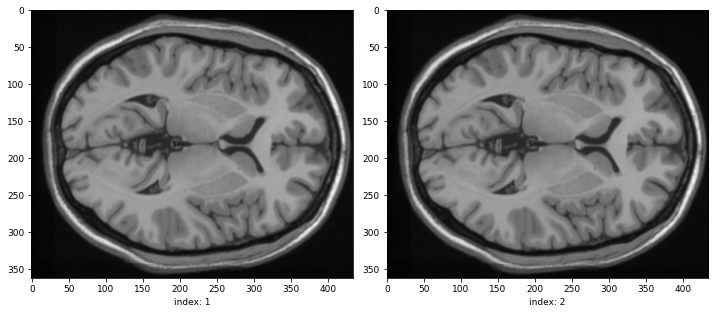

In [224]:
plot_multi([sample, sample_std],fig_size=10)

### Storing the images for understanding the data better

In [188]:
### creating a folder to store images
data_folder = 'data'
os.makedirs('data',exist_ok=True)

In [189]:
images = []
labels = []
for i in range(10):
    img = T1[:,:,i]
    
    ### standardising the float values between int of range(0-255)
    img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    images.append(img)
    lab = label[:,:,i]
    labels.append(lab)
#     lab1 = ((lab - lab.min()) * (1/(lab.max() - lab.min()) * 255)).astype('uint8')
    lab1 = imshow_components(lab)
    cv2.imwrite(os.path.join(data_folder,f'{i}_image.png'),img)
    cv2.imwrite(os.path.join(data_folder,f'{i}_gt.png'),lab)
    cv2.imwrite(os.path.join(data_folder,f'{i}_image_gt.png'),lab1)
    
###reference: https://stackoverflow.com/a/49922520/9605907

In [190]:
### listing the created images in the data folder
sorted(os.listdir(data_folder))[0:10]

['.DS_Store',
 '0_gt.png',
 '0_image.png',
 '0_image_gt.png',
 '1_gt.png',
 '1_image.png',
 '1_image_gt.png',
 '2_gt.png',
 '2_image.png',
 '2_image_gt.png']

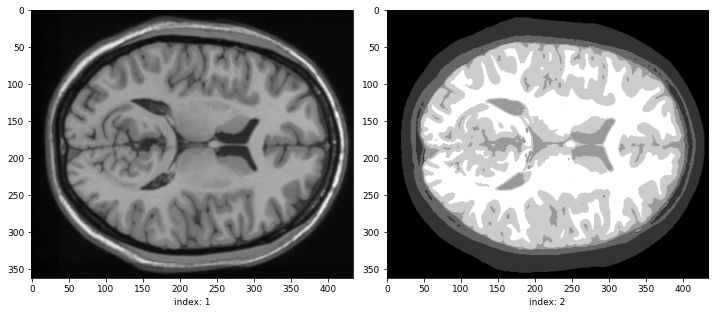

In [225]:
### Visualising a sample input image and it's expected groundtruth
plot_multi([images[9],labels[9]],cmap = 'gray',fig_size=10)

### Segementation classes

- For a given MRI image, we need to segment them into 6 categories namely: air, skin, skull, csf, gray matter and white matter

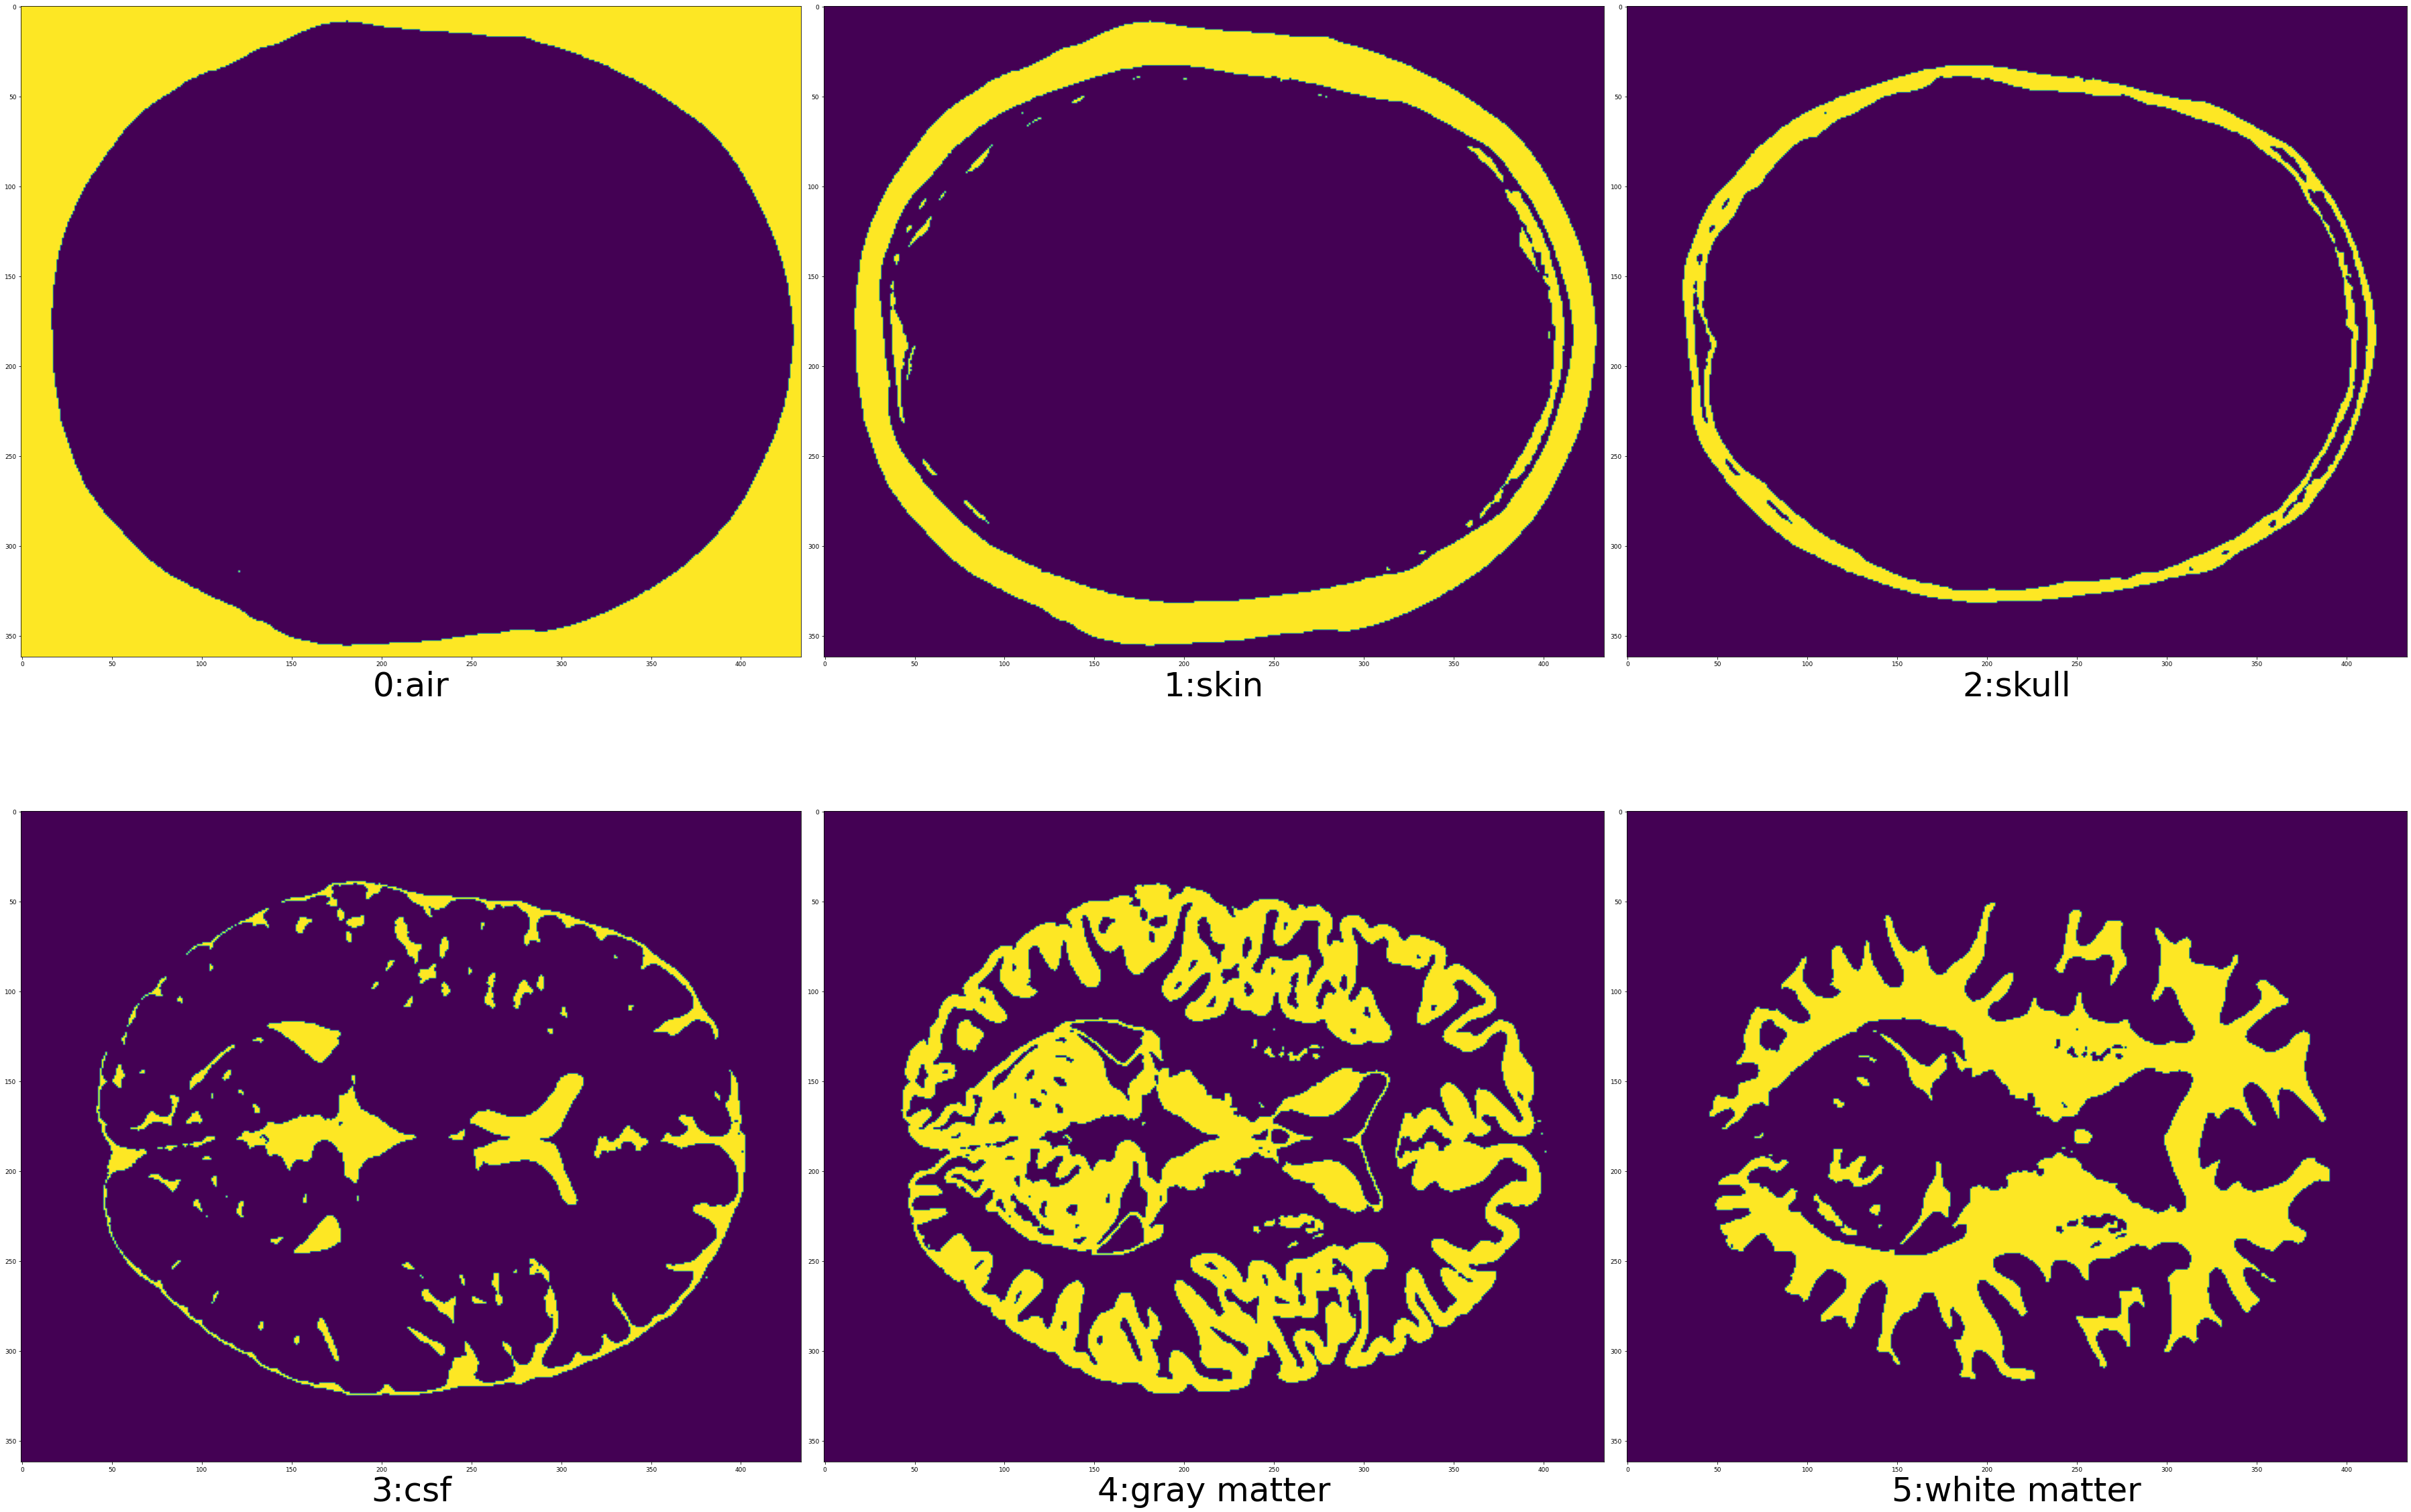

In [226]:
input_image = images[5]
label_image = labels[5]
label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(50, 50))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(label_image==i)
    plt.xlabel(f"{i}:{label_index[i]}",fontsize=50)

## Evaluating the performance
- Before we move on to different approaches in obtaining the segmentation, we will first define the evaluation metrics and get an accuracy measure with the groundtruth and verify the logics. 

In [227]:
def pixelwise_IOU_label(input_image, ground_truth, label_class = 1):
    mask1 = input_image == label_class
    mask2 = ground_truth == label_class
    iou_score = IOU_binary(mask1, mask2)
    return iou_score

In [228]:
def IOU_binary(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [229]:
def dice_binary(mask1, mask2):
    mask1_pos = mask1.astype(np.float32)
    mask2_pos = mask2.astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

In [197]:
# def categorical_dice_label(mask1, mask2, label_class = 1):
#     """
#     Dice score of a specified class between two volumes of label masks.
#     (classes are encoded but by label class number not one-hot )
#     Note: stacks of 2D slices are considered volumes.

#     Args:
#         mask1: N label masks, numpy array shaped (H, W, N)
#         mask2: N label masks, numpy array shaped (H, W, N)
#         label_class: the class over which to calculate dice scores

#     Returns:
#         volume_dice
#     """
#     mask1_pos = (mask1 == label_class).astype(np.float32)
#     mask2_pos = (mask2 == label_class).astype(np.float32)
#     dice = dice_binary(mask1_pos,mask2_pos)
#     return dice

In [198]:
def score_image(predict, label):
    label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
    scores = []
    for pix_val, category in label_index.items():
        predict_mask = (predict == pix_val)
        label_mask = (label == pix_val)        
        dice = dice_binary(predict_mask, label_mask)
        scores.append(dice)
    return scores

In [199]:
import pandas as pd

def score_images(predicts, labels):
    df = pd.DataFrame(columns=['air','skin','skull','csf','gray matter','white matter','average'])
    for i, (predict, label) in enumerate(zip(predicts,labels)):
        scores = calculate_dice(predict,label)
        scores.append(sum(scores)/len(scores))
        df.loc[i] = scores
    print("Dice scores:")
    for label in df.columns:
        print(f"{label} : {df[label].mean()}")
    return df
def score_images(predicts, labels):
    df = pd.DataFrame(columns=['air','skin','skull','csf','gray matter','white matter','average'])
    for i, (predict, label) in enumerate(zip(predicts,labels)):
        scores = score_image(predict,label)
        scores.append(sum(scores)/len(scores))
        df.loc[i] = scores
    print("Dice scores:")
    for label in df.columns:
        print(f"{label} : {df[label].mean()}")
    return df
df = score_images(labels,labels)
df

Dice scores:
air : 1.0
skin : 1.0
skull : 1.0
csf : 1.0
gray matter : 1.0
white matter : 1.0
average : 1.0


air  skin  skull  csf  gray matter  white matter  average
0  1.0   1.0    1.0  1.0          1.0           1.0      1.0
1  1.0   1.0    1.0  1.0          1.0           1.0      1.0
2  1.0   1.0    1.0  1.0          1.0           1.0      1.0
3  1.0   1.0    1.0  1.0          1.0           1.0      1.0
4  1.0   1.0    1.0  1.0          1.0           1.0      1.0
5  1.0   1.0    1.0  1.0          1.0           1.0      1.0
6  1.0   1.0    1.0  1.0          1.0           1.0      1.0
7  1.0   1.0    1.0  1.0          1.0           1.0      1.0
8  1.0   1.0    1.0  1.0          1.0           1.0      1.0
9  1.0   1.0    1.0  1.0          1.0           1.0      1.0

## MRI Segementation - Approach 1 : Multi Thresholding

- From the data, we can see that the pixels values are different for different segments and we can arrive at a basic segmentaion model by applying thresholding at multiple levels. 

### Plotting Histogram of a sample image 

(0.0, 256.0)

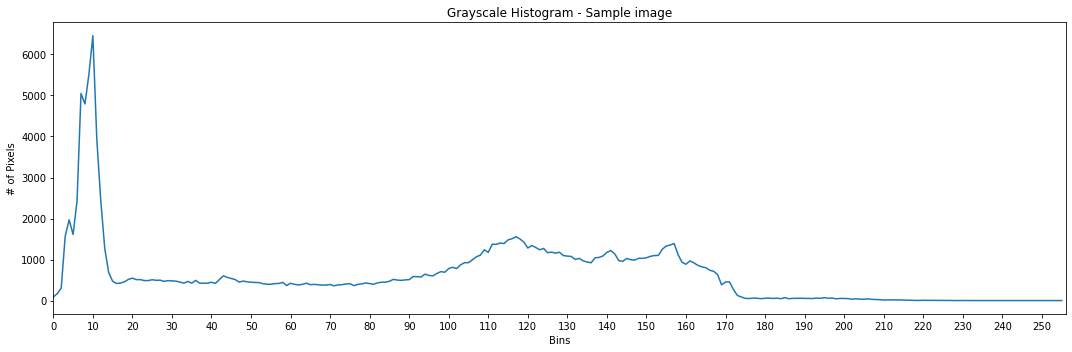

In [200]:
blur_image = cv2.GaussianBlur(input_image,(5,5),cv2.BORDER_DEFAULT)
hist = cv2.calcHist([blur_image], [0], None, [256], [0, 256])
plt.rcParams["figure.figsize"] = [15,5]
plt.rcParams["figure.autolayout"] = True
plt.figure()
plt.title("Grayscale Histogram - Sample image")
plt.xlabel("Bins")
plt.xticks(list(range(0,255,10)))
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

- From the histogram, we can see that there are some peaks which might be representing a particular class of interest

- To arrive at thresholds which will hold for all 10 images, creating an average image and taking the histogram

In [201]:
avg_image = np.mean(images, axis=0).astype(np.uint8)
avg_image.shape

(362, 434)

(0.0, 256.0)

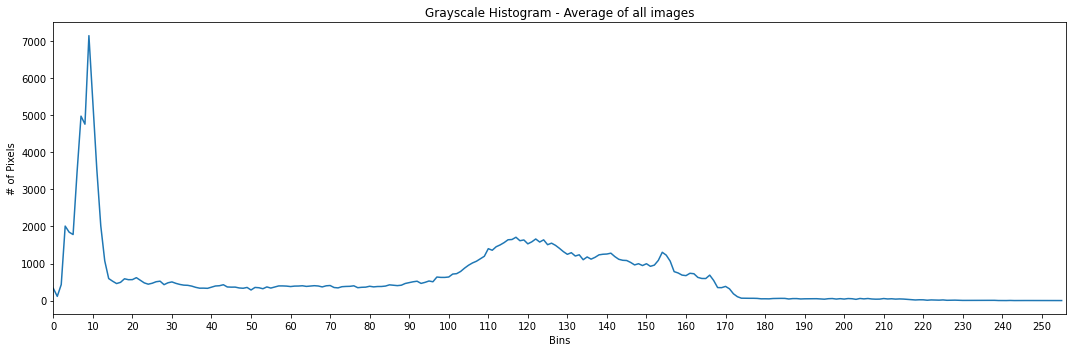

In [202]:
hist = cv2.calcHist([avg_image], [0], None, [256], [0, 256])
plt.rcParams["figure.figsize"] = [15,5]
plt.rcParams["figure.autolayout"] = True
plt.figure()
plt.title("Grayscale Histogram - Average of all images")
plt.xlabel("Bins")
plt.xticks(list(range(0,255,10)))
plt.ylabel("# of Pixels")
plt.plot(hist)
plt.xlim([0, 256])

[ 27  63  97 124 149]


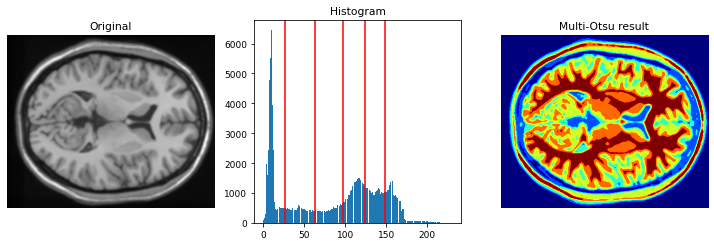

In [203]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
image = blur_image.copy()

# Applying multi-Otsu threshold for the default value, generating
# 6 classes.
thresholds = threshold_multiotsu(image,classes=6)

print(thresholds)
# Using the threshold values, we generate the 6 regions.
regions = np.digitize(image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()
# source: https://scikit-image.org/docs/stable/install.html

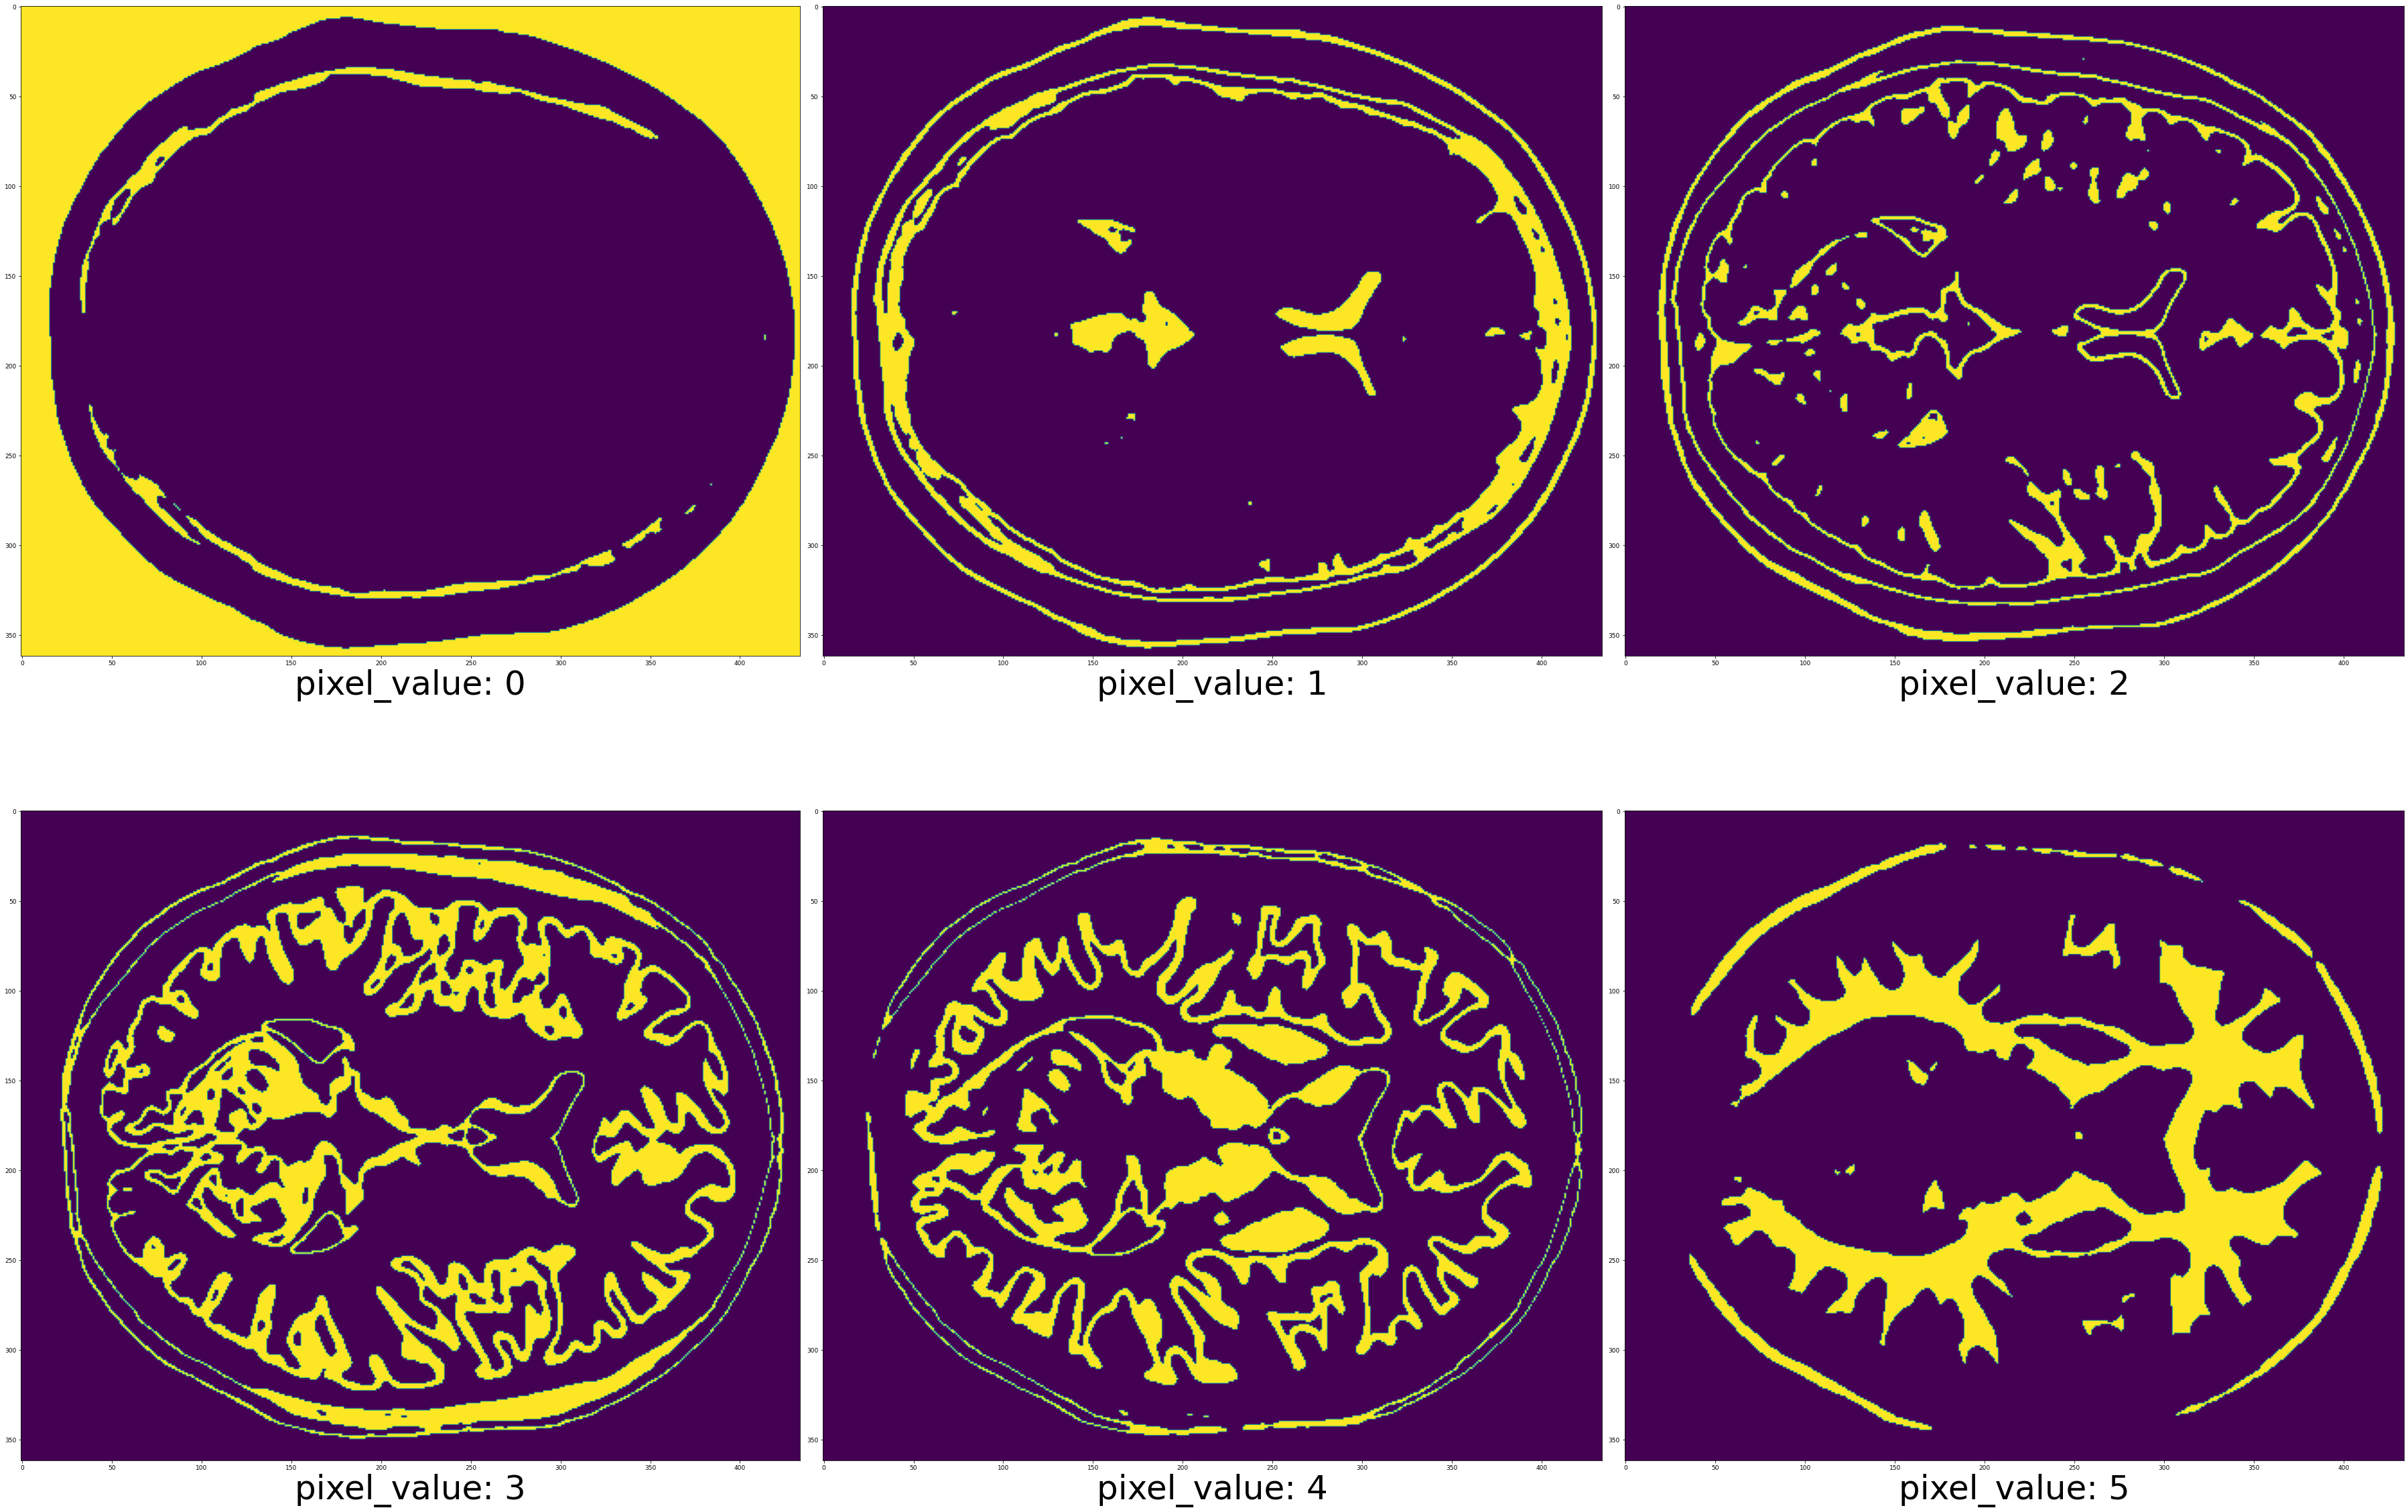

In [204]:
# label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(50, 50))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(regions==i)
    plt.xlabel(f"pixel_value: {i}",fontsize=50)

In [205]:
### evaluating for each class
def match_and_score(predict_image, label_image):
    label_list = np.unique(predict_image)
    label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
    dice_score = []
    match_dict = {}
    score = {}
    dice_scores = []
    for l in label_list:
        ground_list = []
        max_score = 0
        for k in label_index.keys():
            iou = IOU_binary(predict_image == l, label_image == k)
            dice = dice_binary(predict_image == l, label_image == k)
            ground_list.append(dice)
        dice_scores.append(ground_list)
    df = pd.DataFrame(dice_scores)
    return df

In [206]:
df = match_and_score(regions, label_image)
df

0         1         2         3         4         5
0  0.936923  0.000000  0.128241  0.000000  0.000000  0.000000
1  0.069458  0.197042  0.462487  0.323057  0.000000  0.000000
2  0.000000  0.299420  0.000162  0.474435  0.122586  0.000000
3  0.000000  0.261366  0.000000  0.009975  0.672181  0.000128
4  0.000000  0.118473  0.000000  0.000586  0.373255  0.393311
5  0.000000  0.156605  0.000000  0.000000  0.000000  0.725307

In [207]:
df.max(axis=0).mean()

0.5951256348023733

## MRI Segementation - Approach 2 : K-means Clustering

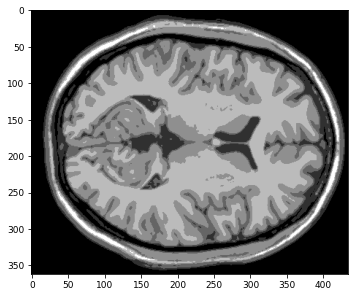

In [543]:
#### method 1
from skimage import io
from sklearn import cluster
import matplotlib.pyplot as plt

image = input_image.copy()
h, w = image.shape
# reshape to 1D array
image_2d = image.reshape(h*w,1)

image_2d = np.float32(image_2d)

### using cv2 kmeans
### In criteria, we first set the algorithm termination criteria, either max no of iterations or desired result 
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 1.0)
K = 6
attempts = 50
ret,label,center=cv2.kmeans(image_2d,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((image.shape))
show_image(result_image)
# print()

<ipython-input-544-93ace7cf0fcd>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,i+1)


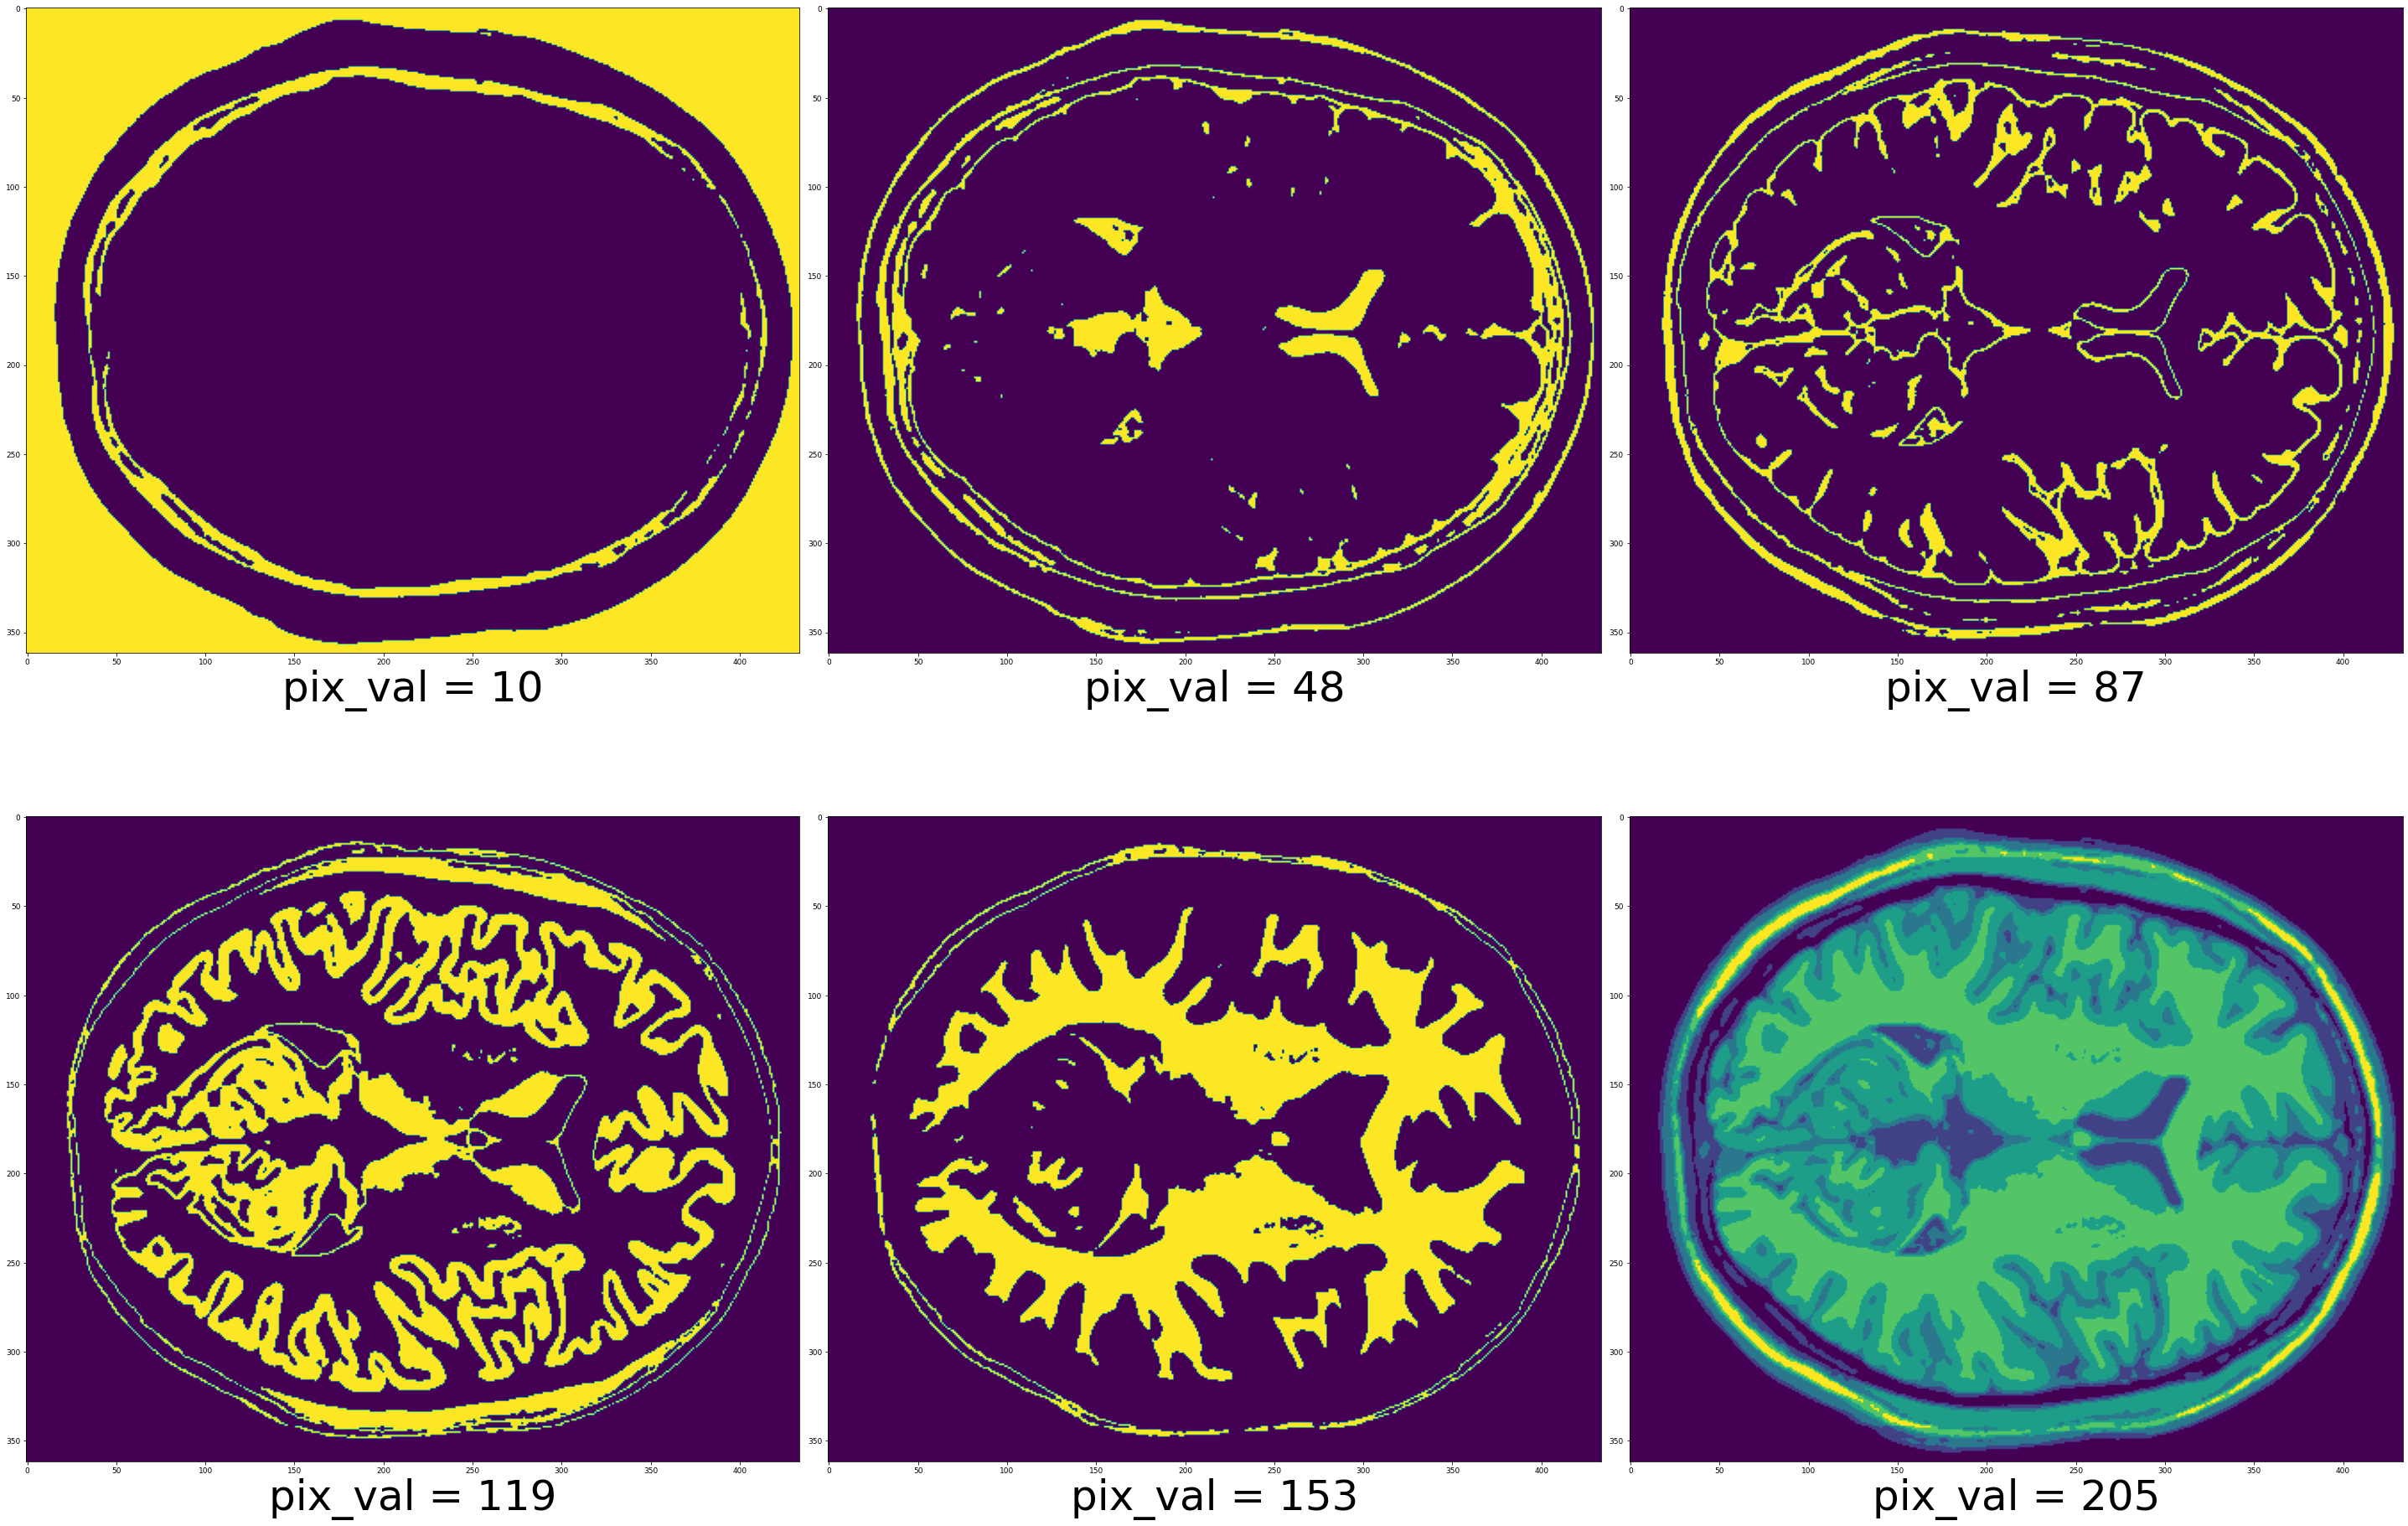

In [544]:
# label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(40, 40))
np.unique(result_image)
for i,code in enumerate(np.unique(result_image)):
    plt.subplot(3,3,i+1)
    plt.imshow(result_image==code)
    plt.xlabel(f"pix_val = {code}",fontsize=50)
plt.subplot(3,3,i+1)
plt.imshow(result_image)


In [545]:
from collections import defaultdict
### evaluating for each class
# predict_image = result_image
df = match_and_score(result_image, label_image)
df


0         1         2         3         4         5
0  0.917493  0.000000  0.218708  0.000000  0.000000  0.000000
1  0.042174  0.239638  0.254176  0.475232  0.000000  0.000000
2  0.000000  0.332434  0.000000  0.310178  0.238231  0.000000
3  0.000000  0.214468  0.000000  0.004836  0.820272  0.000000
4  0.000000  0.100343  0.000000  0.000263  0.009789  0.950255
5  0.000000  0.180659  0.000000  0.000000  0.000000  0.000000

In [546]:
df.max(axis=0).mean()

0.624976976566071

## MRI Segementation - Approach 2 : Filtering & Morphological operations

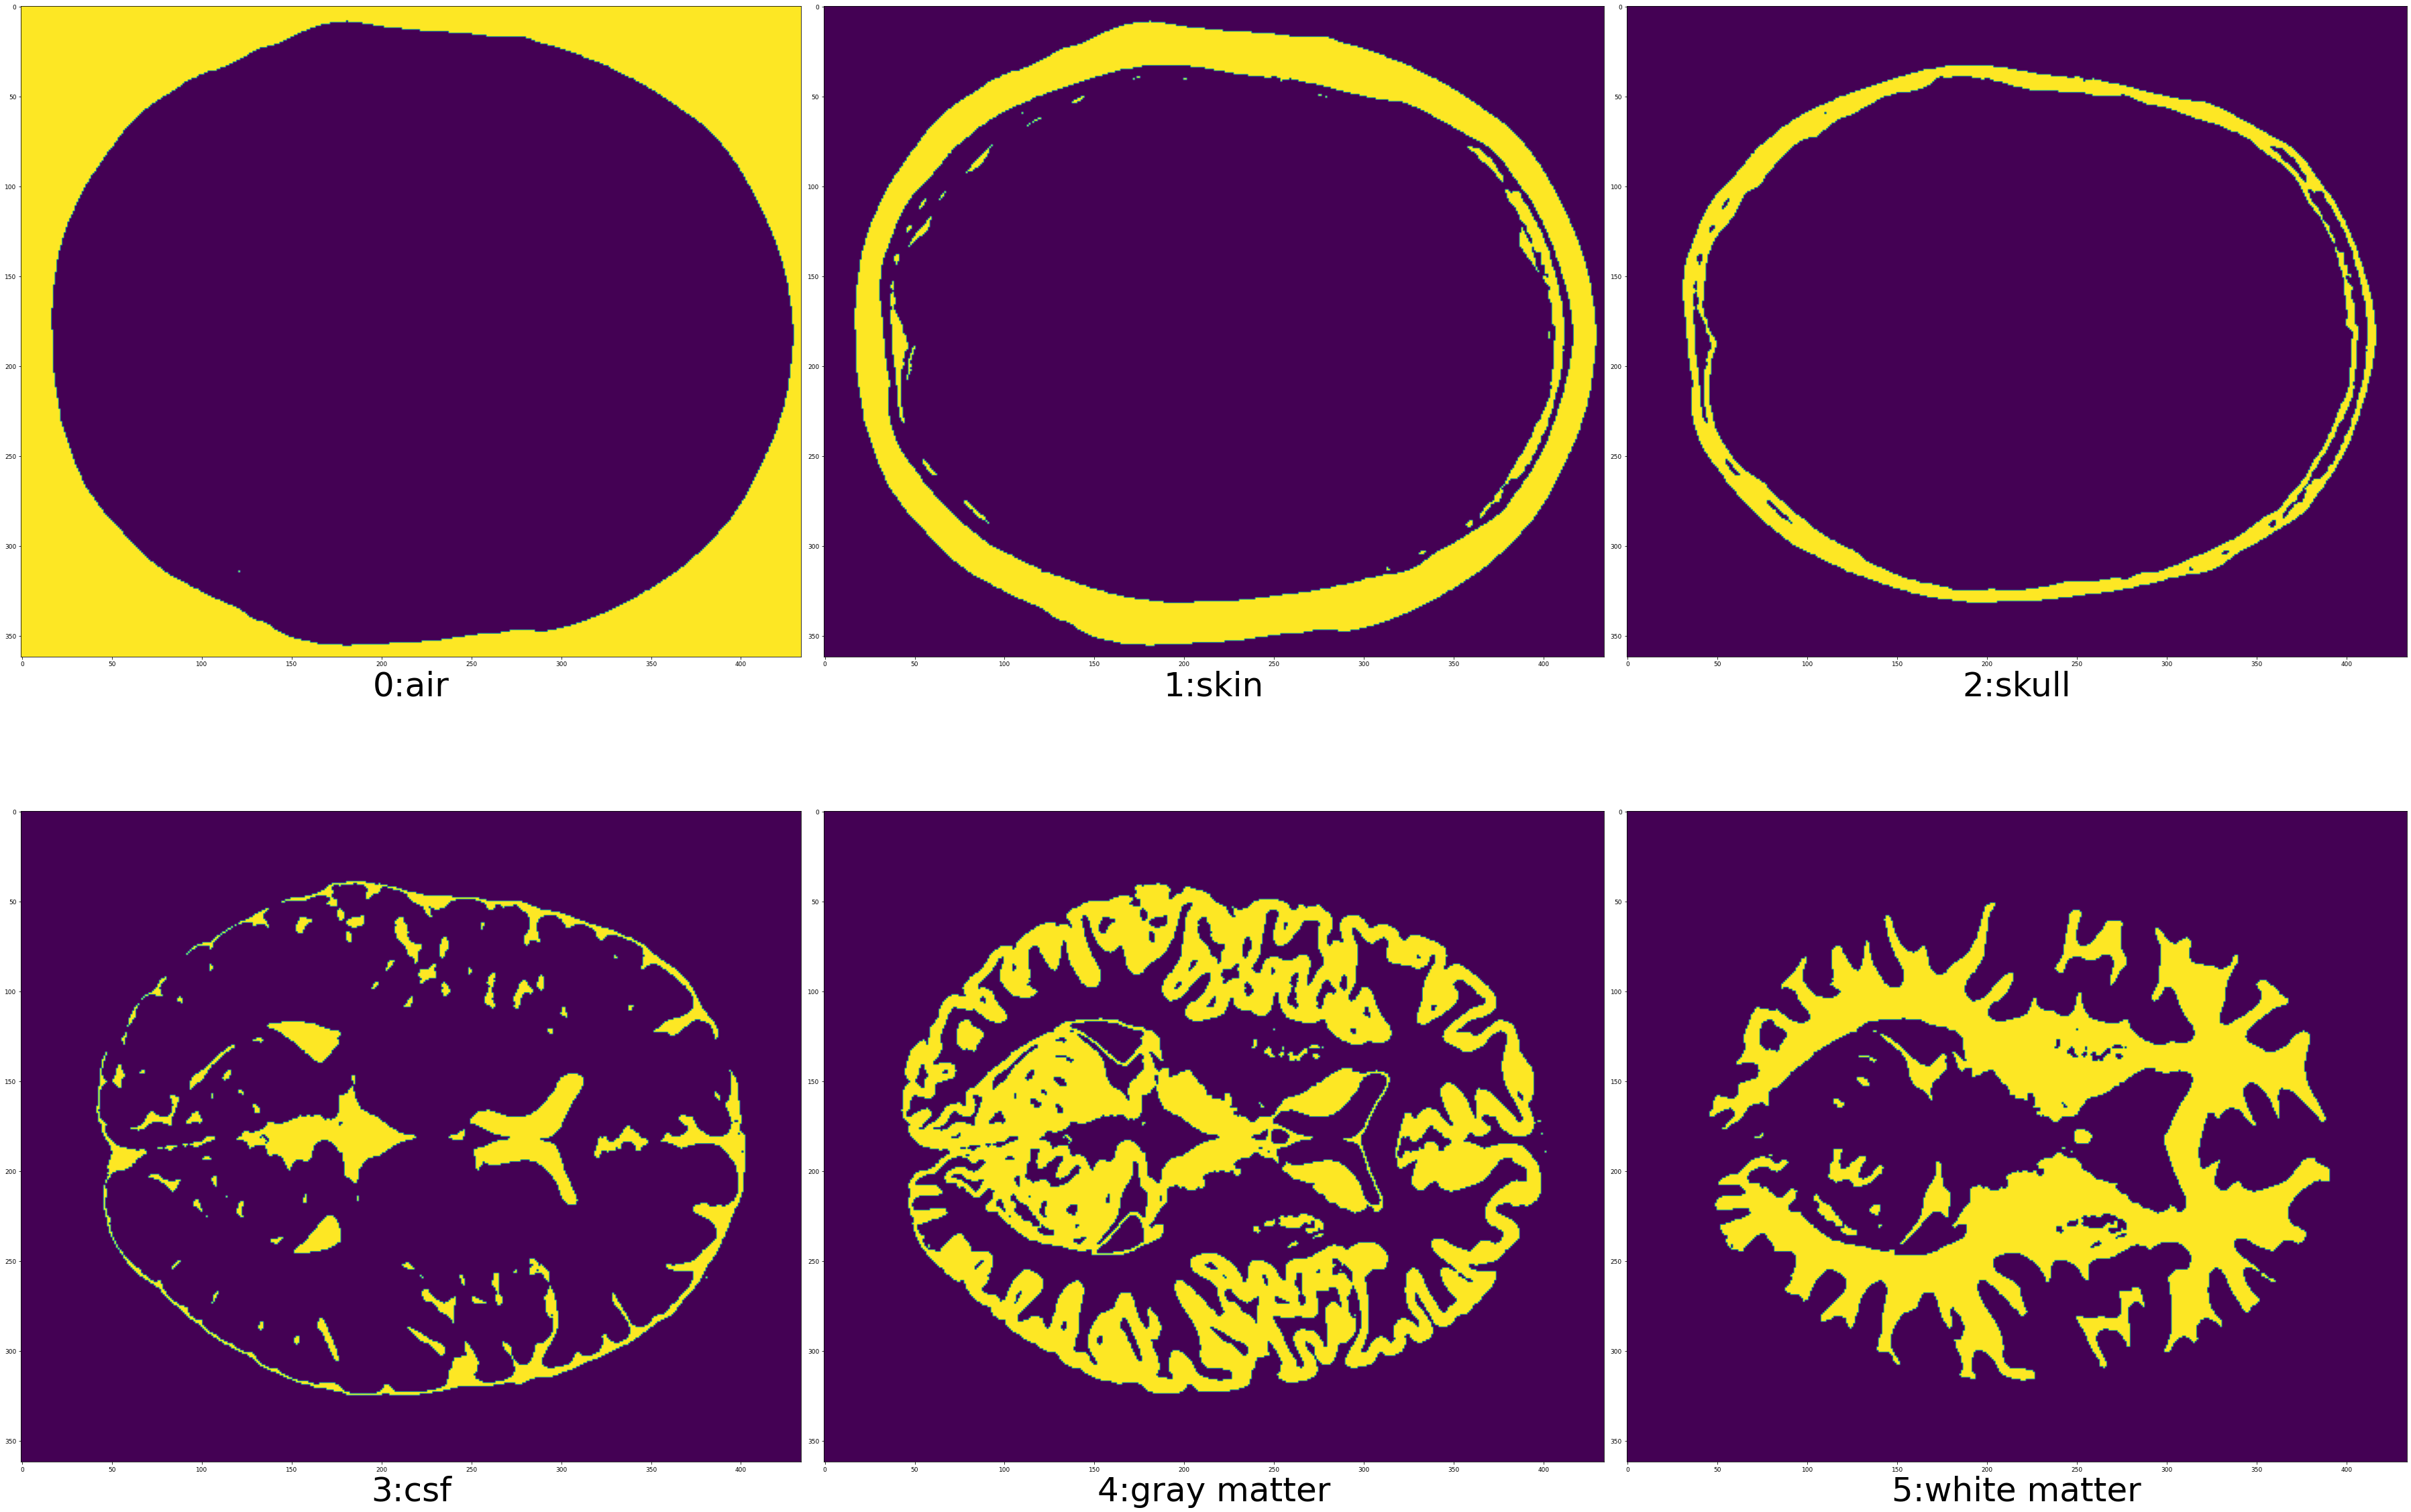

In [547]:
label_index = {0:'air',1:'skin',2:'skull',3:'csf',4:'gray matter',5:'white matter'}
plt.figure(figsize=(50, 50))
for i in range(6):
    plt.subplot(3,3,i+1)
    plt.imshow(label_image==i)
    plt.xlabel(f"{i}:{label_index[i]}",fontsize=50)

In [548]:
blur_image = cv2.GaussianBlur(input_image,(5,5),cv2.BORDER_DEFAULT)

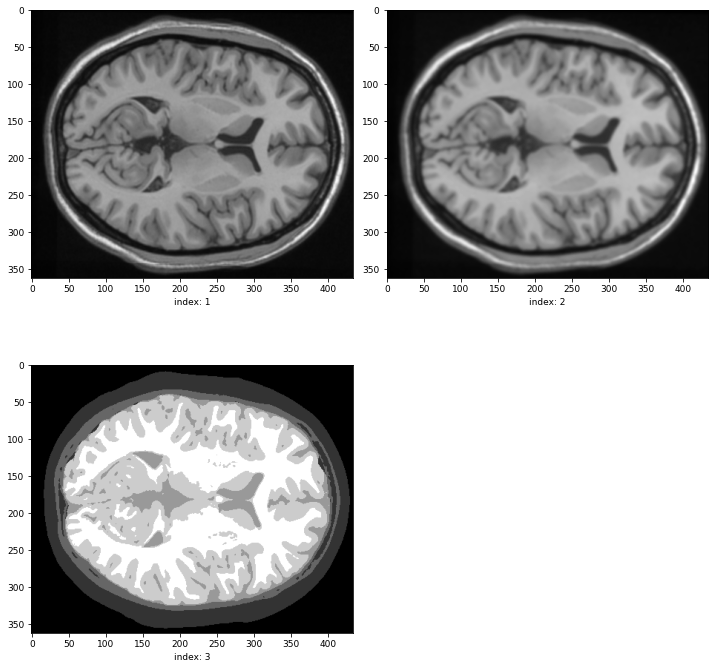

In [549]:
plot_multi([input_image,blur_image,label_image], fig_size=10)

In [550]:
### plotting images cut at multiple thresholds for the blurred image

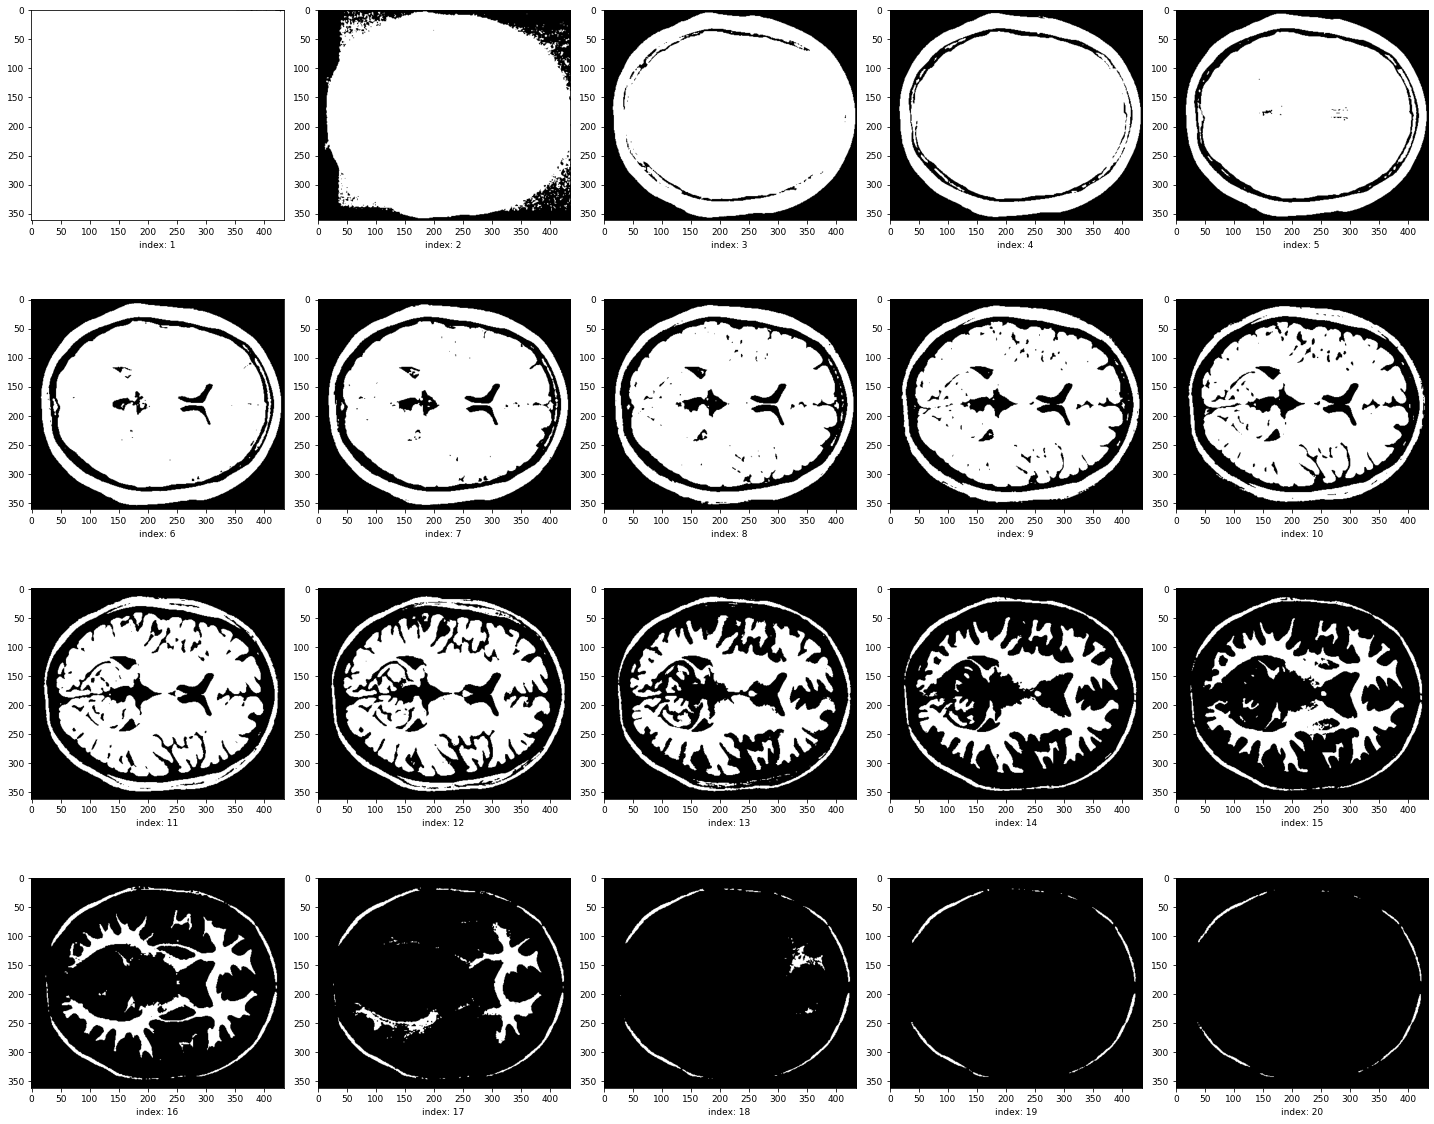

In [683]:
thresh_images = []
for i in range(0,200,10):
    _, thresh = cv2.threshold(input_image, i, 255, cv2.THRESH_BINARY)
    thresh_images.append(thresh)
plot_multi(thresh_images)

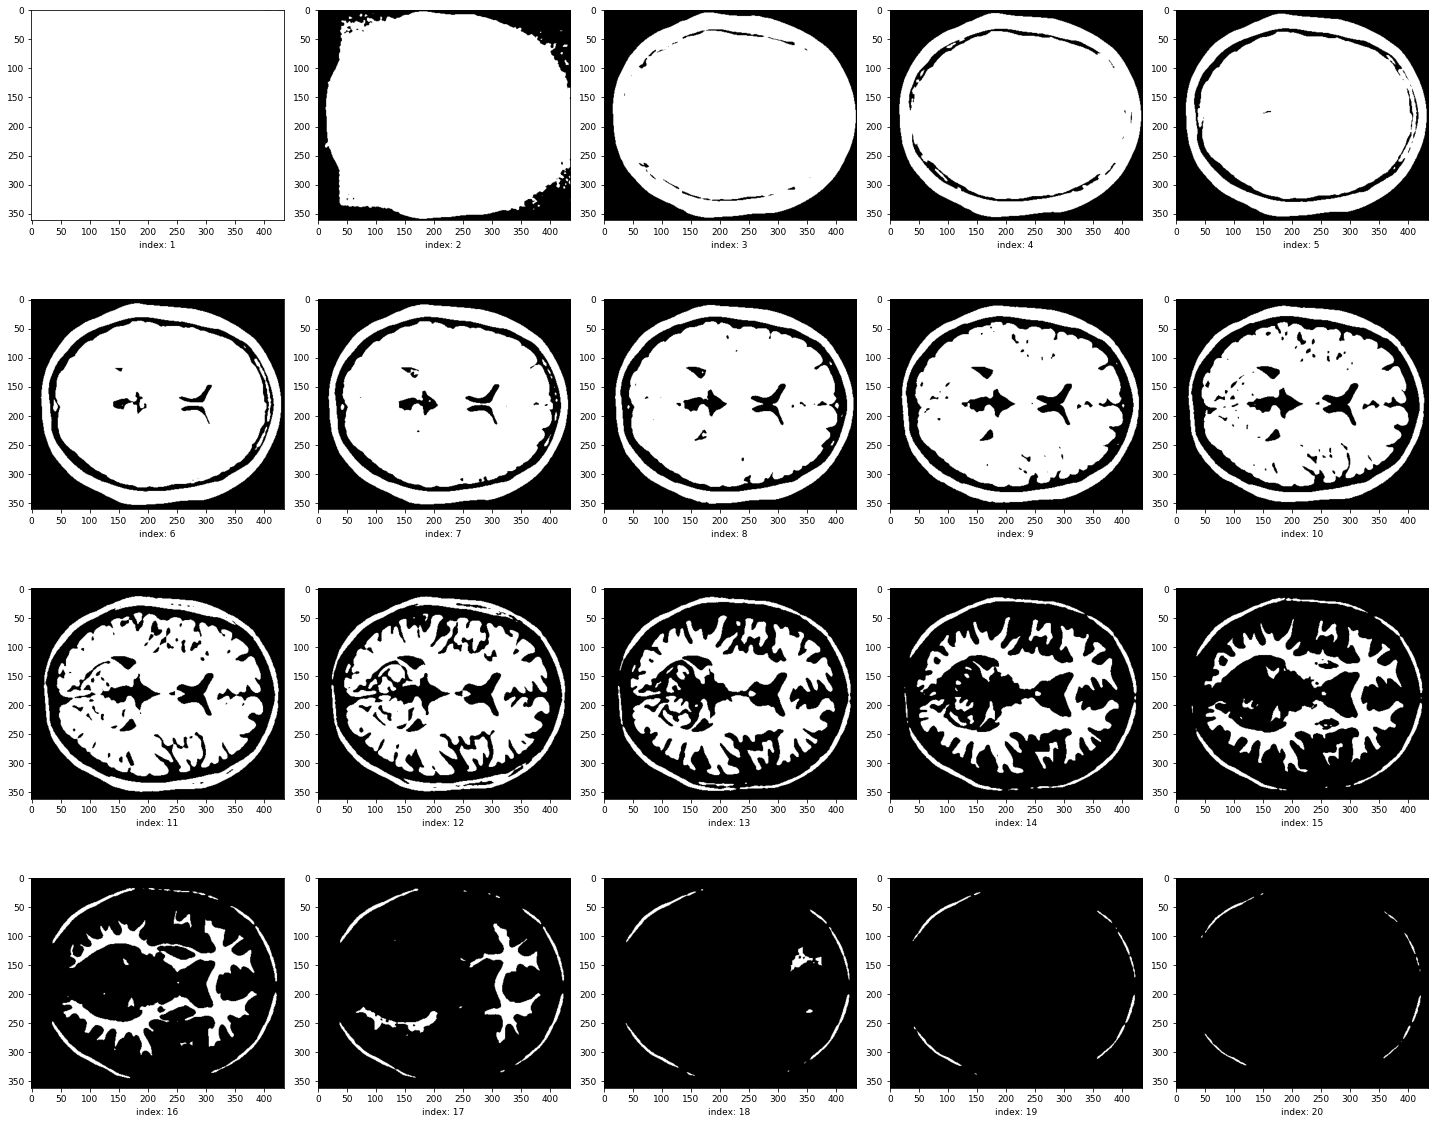

In [684]:
thresh_images = []
for i in range(0,200,10):
    _, thresh = cv2.threshold(blur_image, i, 255, cv2.THRESH_BINARY)
    thresh_images.append(thresh)
plot_multi(thresh_images)
    

### Detecting 0: AIR

array([  0, 255], dtype=uint8)

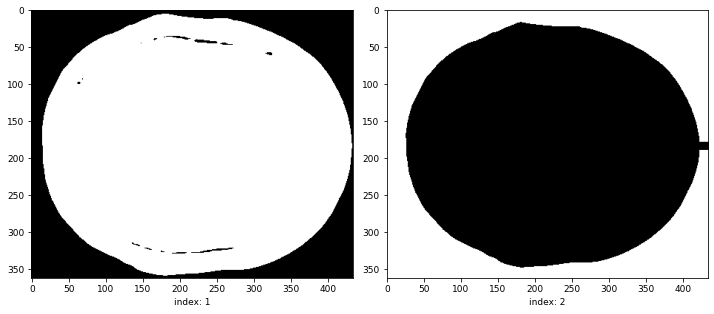

In [685]:
out_image = np.zeros_like(label_image)
_, air = cv2.threshold(blur_image, 17 , 255, cv2.THRESH_BINARY)
kernel = np.ones((5,5),dtype=np.uint8)
air_mask = ~cv2.morphologyEx(air, cv2.MORPH_CLOSE, kernel,iterations = 1)
air_mask = cv2.morphologyEx(air_mask, cv2.MORPH_DILATE, kernel, iterations =5)
plot_multi([air,air_mask],fig_size = 10)
np.unique(air_mask)

### Detecting 1: Skin

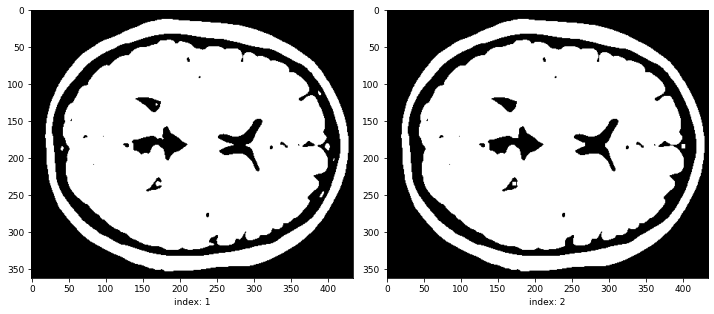

In [686]:
th, skin = cv2.threshold(blur_image, 70, 255, cv2.THRESH_BINARY)
kernel = np.ones((5,5),dtype=np.uint8)
dst2_open = cv2.morphologyEx(skin, cv2.MORPH_OPEN, kernel,iterations = 1)
plot_multi([skin, dst2_open], fig_size = 10)

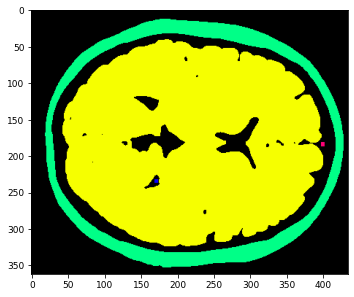

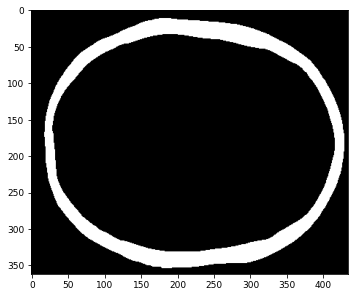

In [687]:
retval, out_label, stats, centroids = cv2.connectedComponentsWithStats(dst2_open)
skin_mask = (out_label==1).astype(np.uint8)
kernel = np.ones((3,3),dtype=np.uint8)
skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_DILATE, kernel,iterations = 1)
show_image(imshow_components(out_label))
show_image(skin_mask)

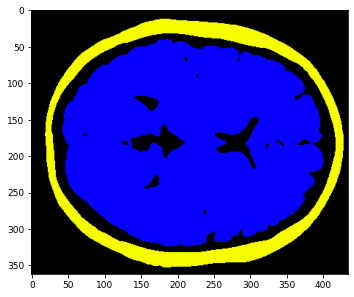

array([0, 1, 2], dtype=int32)

In [688]:
def filter_noise_label(out_label):
    for i in np.unique(out_label):
        if np.count_nonzero(out_label==i)<(0.1*out_label.shape[0]*out_label.shape[1]):
            out_label = np.where(out_label==i,0,out_label)
    return out_label

out_label = filter_noise_label(out_label)
show_image(imshow_components(out_label))
np.unique(out_label)

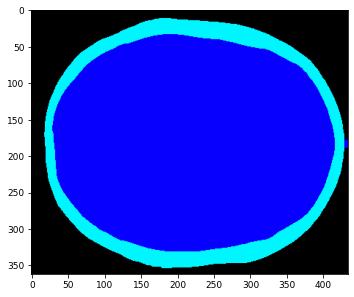

[0.9883851543049041, 0.9249499291131265, 0.0, 0.0, 0.0, 0.0]

In [689]:
out_image = np.zeros_like(input_image)
out_image = np.where(air_mask!=0,0,6)
out_image = np.where(skin_mask!=0,1,out_image)
show_image(imshow_components(out_image))
score_image(out_image, label_image)

### Detecting 2: Skull

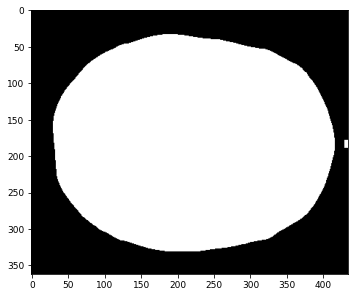

In [690]:
inside_skin = np.zeros_like(out_image)
inside_skin = np.where(out_image < 5,255,0)
# show_image(inside_skin)
kernel = np.ones((9,9),dtype=np.uint8)
inside_skin = cv2.morphologyEx(inside_skin.astype(np.uint8), cv2.MORPH_CLOSE, kernel,iterations = 1)
show_image(~inside_skin)

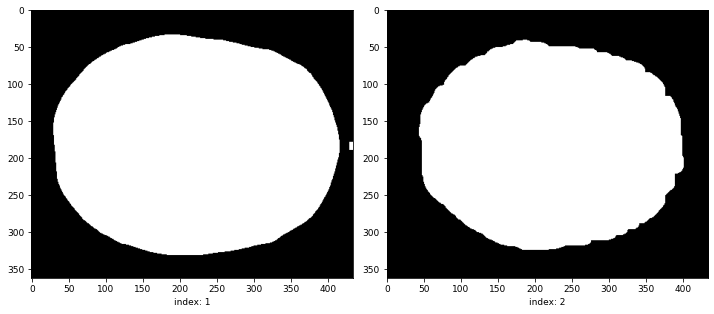

In [691]:
brain = np.where(out_label==2,255,0)
kernel = np.ones((7,7),dtype=np.uint8)
brain_filled = cv2.morphologyEx(brain.astype(np.uint8), cv2.MORPH_CLOSE, kernel,iterations = 5)
plot_multi([~inside_skin, brain_filled],fig_size=10)

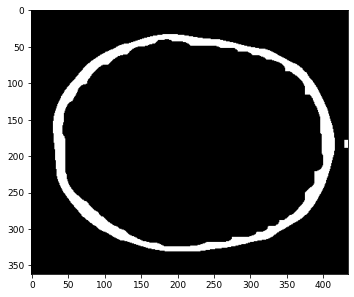

array([  0, 255], dtype=uint8)

In [692]:
skull_mask = np.bitwise_xor(~inside_skin, brain_filled)
show_image(skull_mask)
np.unique(skull_mask)

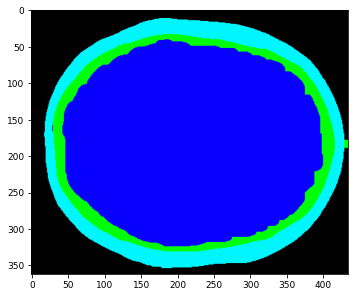

[0.9883851543049041, 0.9249499291131265, 0.8066179437743801, 0.0, 0.0, 0.0]

In [693]:
out_image = np.zeros_like(input_image)
out_image = np.where(air_mask!=0,0,6)
out_image = np.where(skin_mask!=0,1,out_image)
out_image = np.where(skull_mask!=0,2,out_image)
show_image(imshow_components(out_image))
score_image(out_image, label_image)

### Detecting 3: CSF

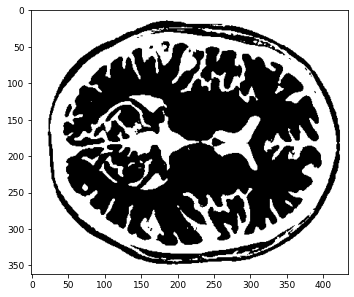

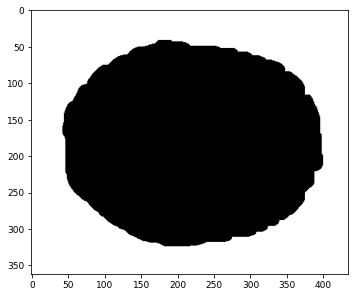

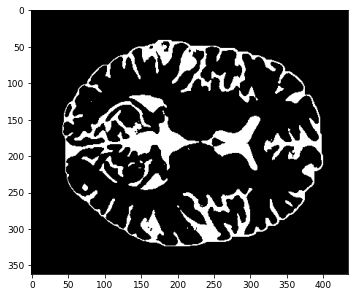

In [694]:

_, csf = cv2.threshold(input_image, 110 , 255, cv2.THRESH_BINARY)

show_image(~csf,fig_size = 5)
inside_skull = np.zeros_like(out_image)
inside_skull = np.where(out_image<5, 255, 0).astype(np.uint8)

kernel = np.ones((7,7),dtype=np.uint8)
inside_skull = cv2.morphologyEx(inside_skull, cv2.MORPH_CLOSE, kernel,iterations = 1)
show_image(inside_skull)
csf = np.bitwise_xor(csf,~inside_skull)
csf = np.where(out_image>5, csf, 0)
show_image(csf)

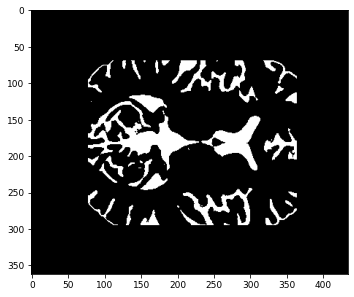

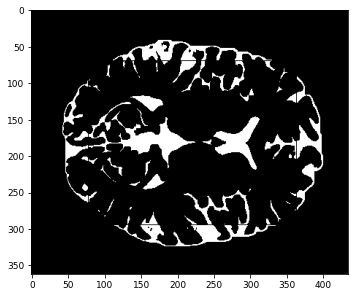

In [695]:
retval, out_label_csf, stats, centroids = cv2.connectedComponentsWithStats(csf)
x, y, w, h, area = sorted(stats,key = lambda x:x[4],reverse = True)[1]
csf_centre_thin = np.zeros_like(csf)
csf_centre_thin[int(y+0.1*h):int(y+0.9*h),int(x+0.1*w):int(x+0.9*w)] = csf[int(y+0.1*h):int(y+0.9*h),int(x+0.1*w):int(x+0.9*w)]

show_image(csf_centre_thin)

kernel = np.ones((3,3),dtype=np.uint8)
csf_centre_thin = cv2.morphologyEx(csf_centre_thin, cv2.MORPH_ERODE, kernel,iterations = 1)
csf[int(y+0.1*h):int(y+0.9*h),int(x+0.1*w):int(x+0.9*w)] = csf_centre_thin[int(y+0.1*h):int(y+0.9*h),int(x+0.1*w):int(x+0.9*w)]
show_image(csf)

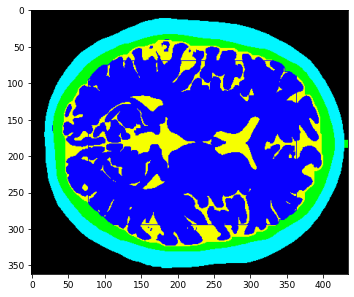

[0.9883851543049041,
 0.9249499291131265,
 0.8066179437743801,
 0.6445172360006239,
 0.0,
 0.0]

In [696]:
out_image = np.where(csf!=0, 3, out_image)
show_image(imshow_components(out_image))
score_image(out_image, label_image)


### Detecting 5: White Matter

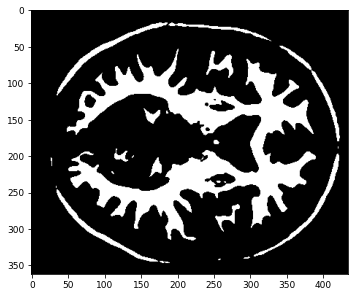

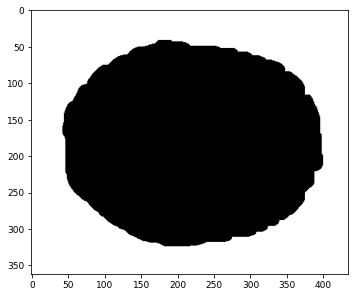

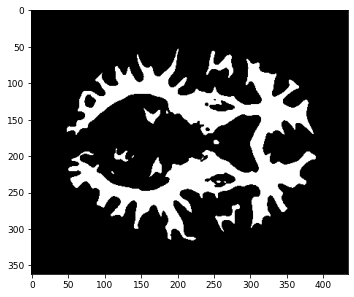

In [697]:
_, gray_matter = cv2.threshold(blur_image, 140 , 255, cv2.THRESH_BINARY)
show_image(gray_matter)

show_image(inside_skull)
gray_matter = np.where(~inside_skull>0, gray_matter,0)
show_image(gray_matter)

[0.9883851543049041,
 0.9249499291131265,
 0.8066179437743801,
 0.6445172360006239,
 0.8554741092077928,
 0.9323764929424538]

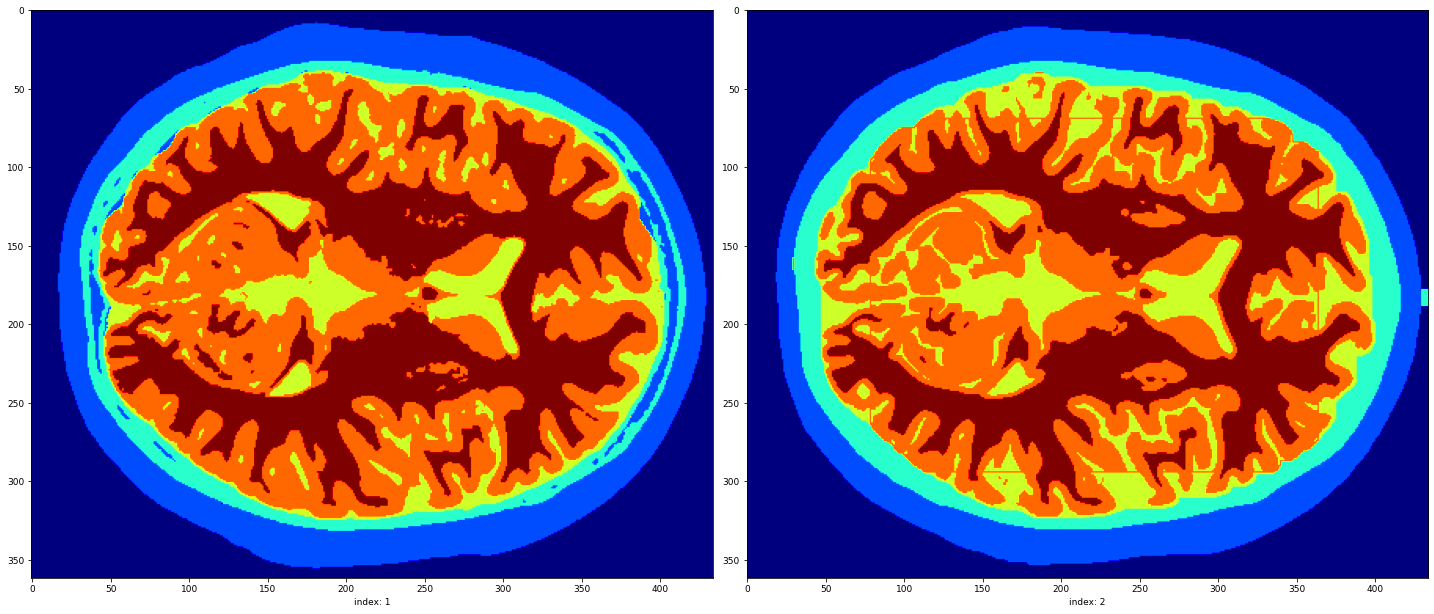

In [698]:
out_image = np.where(gray_matter!=0, 5, out_image)
out_image = np.where(out_image>5, 4, out_image)
plot_multi([label_image,out_image], cmap='jet')
out = score_image(out_image, label_image)
out

In [699]:
sum(out)/len(out)

0.8587201442238802

- Overall Dice score is 85%. We will now make a single function to generate this output and score it on all images.

### Approach 3: Final function

In [700]:
def class_wise_segmentation(input_image, intermediate = False):
    blur_image = cv2.GaussianBlur(input_image.copy(),(5,5),cv2.BORDER_DEFAULT)
    out_image = np.zeros_like(label_image)
    
    ### air
    _, air = cv2.threshold(blur_image, 17 , 255, cv2.THRESH_BINARY)
    kernel = np.ones((5,5),dtype=np.uint8)
    air_mask = ~cv2.morphologyEx(air, cv2.MORPH_CLOSE, kernel,iterations = 1)
    air_mask = cv2.morphologyEx(air_mask, cv2.MORPH_DILATE, kernel, iterations =5)

    ### skin
    th, skin = cv2.threshold(blur_image, 70, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5,5),dtype=np.uint8)
    dst2_open = cv2.morphologyEx(skin, cv2.MORPH_OPEN, kernel,iterations = 1)
    retval, out_label, stats, centroids = cv2.connectedComponentsWithStats(dst2_open)
    skin_mask = (out_label==1).astype(np.uint8)
    kernel = np.ones((3,3),dtype=np.uint8)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_DILATE, kernel,iterations = 1)
    out_label = filter_noise_label(out_label)
    out_image = np.where(air_mask!=0,0,6)
    out_image = np.where(skin_mask!=0,1,out_image)

    ## skull
    inside_skin = np.zeros_like(out_image)
    inside_skin = np.where(out_image < 5,255,0)
    kernel = np.ones((9,9),dtype=np.uint8)
    inside_skin = cv2.morphologyEx(inside_skin.astype(np.uint8), cv2.MORPH_CLOSE, kernel,iterations = 1)
    brain = np.where(out_label==2,255,0)
    kernel = np.ones((7,7),dtype=np.uint8)
    brain_filled = cv2.morphologyEx(brain.astype(np.uint8), cv2.MORPH_CLOSE, kernel,iterations = 5)
    skull_mask = np.bitwise_xor(~inside_skin, brain_filled)
    out_image = np.where(air_mask!=0,0,6)
    out_image = np.where(skin_mask!=0,1,out_image)
    out_image = np.where(skull_mask!=0,2,out_image)
    
    ### csf
    _, csf = cv2.threshold(input_image, 110 , 255, cv2.THRESH_BINARY)
    inside_skull = np.zeros_like(out_image)
    inside_skull = np.where(out_image<5, 255, 0).astype(np.uint8)
    kernel = np.ones((7,7),dtype=np.uint8)
    inside_skull = cv2.morphologyEx(inside_skull, cv2.MORPH_CLOSE, kernel,iterations = 1)
    csf = np.bitwise_xor(csf,~inside_skull)
    csf = np.where(out_image>5, csf, 0)
    kernel = np.ones((3,3),dtype=np.uint8)
    csf = cv2.morphologyEx(csf, cv2.MORPH_ERODE, kernel,iterations = 1)
    out_image = np.where(csf!=0, 3, out_image)
    
    ### gray & white matter
    _, gray_matter = cv2.threshold(blur_image, 140 , 255, cv2.THRESH_BINARY)
    gray_matter = np.where(~inside_skull>0, gray_matter,0)
    out_image = np.where(gray_matter!=0, 5, out_image)
    out_image = np.where(out_image>5, 4, out_image)
    return out_image

In [701]:
out_image = class_wise_segmentation(input_image)
score_image(out_image,label_image)

[0.9883851543049041,
 0.9249499291131265,
 0.8066179437743801,
 0.6756863260212794,
 0.8801331014142025,
 0.9323764929424538]

In [702]:
out_image = class_wise_segmentation(input_image)
score_image(out_image,label_image)

[0.9883851543049041,
 0.9249499291131265,
 0.8066179437743801,
 0.6756863260212794,
 0.8801331014142025,
 0.9323764929424538]

In [703]:
predicts = list(map(lambda x:class_wise_segmentation(x),images))

df = score_images(predicts, labels)
df

Dice scores:
air : 0.9876823749132893
skin : 0.9276853265975289
skull : 0.8005377079288705
csf : 0.6625216575638382
gray matter : 0.8724027072762919
white matter : 0.924378308584876
average : 0.8625346804774491


air      skin     skull       csf  gray matter  white matter   average
0  0.987377  0.928707  0.810709  0.597877     0.800671      0.860210  0.830925
1  0.981509  0.927428  0.776849  0.616889     0.806347      0.861975  0.828500
2  0.981554  0.928567  0.776503  0.633519     0.823383      0.875898  0.836571
3  0.988529  0.927182  0.804459  0.663693     0.868475      0.918585  0.861820
4  0.988636  0.926620  0.806788  0.694022     0.894032      0.939578  0.874946
5  0.988385  0.924950  0.806618  0.675686     0.880133      0.932376  0.868025
6  0.990044  0.928818  0.810239  0.706030     0.912472      0.968085  0.885948
7  0.990649  0.929456  0.807365  0.710521     0.922088      0.970096  0.888363
8  0.990487  0.928098  0.803435  0.681783     0.921369      0.968867  0.882340
9  0.989654  0.927029  0.802411  0.645197     0.895056      0.948114  0.867910

In [704]:
df.mean(axis=1).mean()

0.8625346804774491